In [1]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.layers import Input, Dense, GlobalMaxPooling2D
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

In [3]:
# Directorio de los datos
TRAIN_DATA_DIRECTORY = Path("dataset")

# Tamaño del lote (batch size)
BATCH_SIZE = 32

# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Carga los datos.
dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode=None,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 24335 files.


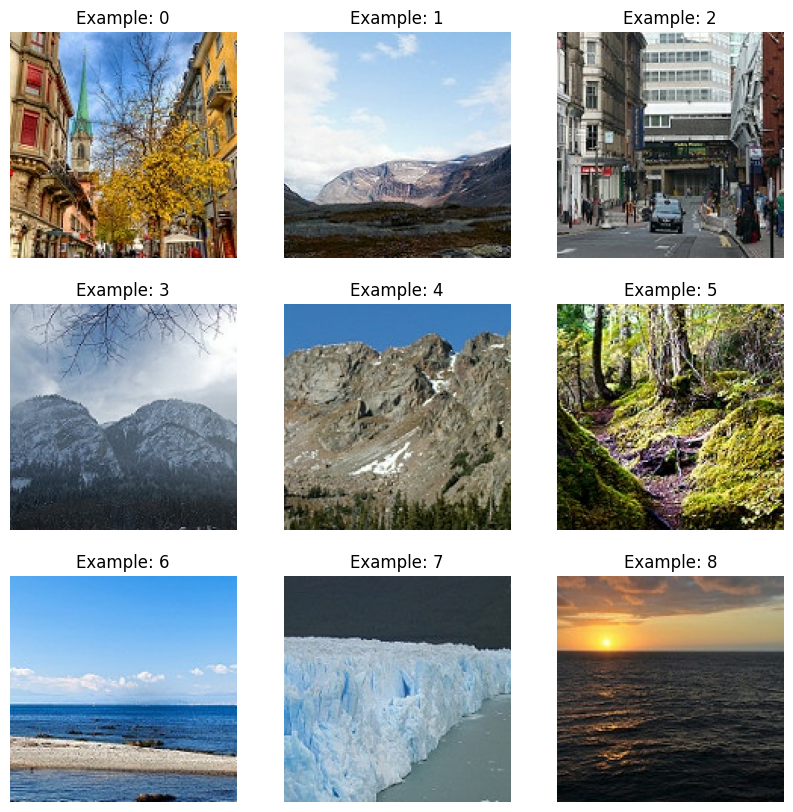

In [4]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Example: {i}")
    plt.axis("off")

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración del generador de datos para aumentar el dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'dataset\seg_train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    'dataset\seg_train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation')


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


# Modelo con Capas Densas

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model_dense = Sequential([
    Flatten(input_shape=(150, 150, 3)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

model_dense.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\src4\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.models import Model

def identity_block(x, filters):
    x_skip = x  # Save the input value
    x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = Add()([x, x_skip])  # Element-wise addition of input and block output
    return x

input_layer = Input(shape=(150, 150, 3))
x = Conv2D(64, (3, 3), activation='relu')(input_layer)
x = identity_block(x, 64)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(6, activation='softmax')(x)

model_residual = Model(inputs=input_layer, outputs=output_layer)
model_residual.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

model_tl = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

model_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [15]:
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Definir una función para entrenar y evaluar el modelo
def train_and_evaluate_model(model, train_generator, validation_generator, test_generator, epochs=10):
    # Entrenar el modelo
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=epochs
    )

    # Evaluar el modelo en el conjunto de test
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_acc}")

    # Obtener predicciones
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    # Calcular métricas
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

    # Graficar precisión y pérdida a lo largo de las épocas
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='upper left')
    plt.show()

    return history

# Cargar y preparar los datos (train, validation y test generators)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'path/to/train/data',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    'path/to/train/data',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    'path/to/test/data',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Modelo 1: Capas Densas
model_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(150, 150, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_dense.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Entrenando modelo con capas densas")
train_and_evaluate_model(model_dense, train_generator, validation_generator, test_generator)

# Modelo 2: Capas Convolucionales y Densas
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Entrenando modelo con capas convolucionales")
train_and_evaluate_model(model_cnn, train_generator, validation_generator, test_generator)

# Modelo 3: Bloque Residual
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.models import Model

def identity_block(x, filters):
    x_skip = x  # Guardar la entrada
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = Add()([x, x_skip])  # Suma de la entrada y la salida del bloque
    return x

input_layer = Input(shape=(150, 150, 3))
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(input_layer)
x = identity_block(x, 64)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output_layer = tf.keras.layers.Dense(6, activation='softmax')(x)

model_residual = Model(inputs=input_layer, outputs=output_layer)
model_residual.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Entrenando modelo con bloques residuales")
train_and_evaluate_model(model_residual, train_generator, validation_generator, test_generator)

# Modelo 4: Transfer Learning con VGG16
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

model_tl = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Entrenando modelo con Transfer Learning (VGG16)")
train_and_evaluate_model(model_tl, train_generator, validation_generator, test_generator)


FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'path/to/train/data'